In [2]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import ConnectionPatch

In [3]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [4]:
meta_activity_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/meta_enhancer_gene.csv"
meta_expression_file = "/data5/deepro/starrseq/papers/results/5_compare_expression_ko_vs_wt/data/meta_exp.csv"

meta_activity_df = pd.read_csv(meta_activity_file)
meta_activity_df =  meta_activity_df.fillna(meta_activity_df.median())

meta_expression_df = pd.read_csv(meta_expression_file)
meta_expression_df =  meta_expression_df.fillna(meta_expression_df.median())


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_4080290/1192526670.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  meta_activity_df =  meta_activity_df.fillna(meta_activity_df.median())
/tmp/ipykernel_4080290/1192526670.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  meta_expression_df =  meta_expression_df.fillna(meta_expression_df.median())


In [5]:
libs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [6]:
def get_fragment_categories(df, libs):
    unresponsive_cond = " & ".join([f"(`{lib}_padj` > 0.01)" for lib in libs])
    induced_cond = "(" + " | ".join([f"(`{lib}_padj` < 0.01) & (`{lib}_log2FoldChange` > 0)" for lib in libs]) + ")" 
    repressed_cond = "(" + " | ".join([f"(`{lib}_padj` < 0.01) & (`{lib}_log2FoldChange` < 0)" for lib in libs]) + ")" 
    active_induced_cond = "(`CC_peak` == 1) & " + "(" + " | ".join([f"(`{lib}_padj` < 0.01) & (`{lib}_peak` == 1) & (`{lib}_log2FoldChange` > 0)" for lib in libs]) + ")" 
    gained_cond = "(`CC_peak` == 0) & " + "(" + " | ".join([f"(`{lib}_padj` < 0.01) & (`{lib}_peak` == 1) & (`{lib}_log2FoldChange` > 0)" for lib in libs]) + ")" 
    lost_cond = "(`CC_peak` == 1) & " + "(" + " | ".join([f"(`{lib}_padj` < 0.01) & (`{lib}_peak` == 0) & (`{lib}_log2FoldChange` < 0)" for lib in libs]) + ")" 
    always_active_cond =  "(`CC_peak` == 1) & " +  " & ".join([f"(`{lib}_peak` == 1)" for lib in libs]) 
    always_inactive_cond =  "(`CC` < -1) & " +  " & ".join([f"(`{lib}` < -1)" for lib in libs]) 

    unresponsive_fragments = df.query(unresponsive_cond)
    induced_fragments = df.query(induced_cond)
    repressed_fragments = df.query(repressed_cond)
    active_induced_fragments = df.query(active_induced_cond)
    always_active_fragments = df.query(always_active_cond)
    always_inactive_fragments = df.query(always_inactive_cond)
    gained_fragments = df.query(gained_cond)
    lost_fragments = df.query(lost_cond)

    maxCol=lambda x: max(x.min(), x.max(), key=abs)
    unresponsive_fragments["abs_mean_fc"] = unresponsive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].mean(axis=1)
    induced_fragments["abs_max_fc"] = induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
    repressed_fragments["abs_max_fc"] = repressed_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].min(axis=1)
    active_induced_fragments["abs_max_fc"] = active_induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
    always_active_fragments["abs_max_fc"] = always_active_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].median(axis=1) #.apply(maxCol,axis=1)
    always_inactive_fragments["abs_max_fc"] = always_inactive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].median(axis=1) #.apply(maxCol,axis=1)
    gained_fragments["abs_max_fc"] = gained_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
    lost_fragments["abs_max_fc"] = lost_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].min(axis=1)
    return unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments

In [7]:
def parse_deseqres_for_volcano_plot(df, lib):
    df = df.loc[:, ["gene_id", "gene_name"] + [c for c in df.columns if c.startswith(lib)]]
    df = df.rename(columns={f"{lib}_log2FoldChange": "log2FoldChange", f"{lib}_padj": "padj"})
    # drop rows with na values
    df = df.dropna()
    # convert all 0 padj values to a tenth of the min padj value thats greater than 0
    df.loc[df.padj==0, "padj"] = min(df.loc[df.padj>0].padj)/10
    # create neglog10 val
    df["neglog10padj"] = -np.log10(df.padj)
    # create hue columns
    lfc_thresh = 0.5
    pv_thresh = 0.01
    df["hue"] = "Not Significant"
    df.loc[(df.log2FoldChange>lfc_thresh)&(df.padj<pv_thresh), "hue"] = "Significant Up"
    df.loc[(df.log2FoldChange<-lfc_thresh)&(df.padj<pv_thresh), "hue"] = "Significant Down"
    return df

In [8]:
unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments = get_fragment_categories(meta_activity_df, [libs[0]])

/tmp/ipykernel_4080290/881193982.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unresponsive_fragments["abs_mean_fc"] = unresponsive_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].mean(axis=1)
/tmp/ipykernel_4080290/881193982.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  induced_fragments["abs_max_fc"] = induced_fragments.loc[:, [f"{lib}_log2FoldChange" for lib in libs]].max(axis=1)
/tmp/ipykernel_4080290/881193982.py:23: SettingWithCopyWarning: 
A value is trying to be set on a co

In [9]:
volcano_df = parse_deseqres_for_volcano_plot(meta_expression_df, libs[0])

In [102]:
def check_sde_helper(gids, meta_exp, lib):
    return meta_exp.loc[meta_exp.gene_id.isin(gids), f"{lib}_padj"].values

# def check_sde(ser, meta_exp, lib):
#     coord = ser.chrom_coord
#     genes = np.array(ser.nearest_gene.split("|"))
#     sdes = check_sde_helper(genes, meta_exp, lib)
#     sde_genes = genes[np.where(sdes<0.01, True, False)]
#     return "|".join(sde_genes)

def check_sde(ser, meta_exp, libs):
    coord = ser.chrom_coord
    genes = np.array(ser.nearest_gene.split("|"))
    sdes = meta_exp.loc[meta_exp.gene_id.isin(genes), [f"{lib}_padj" for lib in libs]].values
    genes = genes.reshape(len(genes),1).repeat(len(libs), 1)
    sde_genes = np.where(sdes<0.01, genes, "")
    data_dict = dict()
    for i,row in enumerate(sde_genes.T):
        data_dict[f"{libs[i]}_sde"] = "|".join(row).strip("|")
    return pd.Series(data_dict)


In [106]:
pd.concat([meta_activity_df.head(50), meta_activity_df.head(50).apply(check_sde,  args=(meta_expression_df, libs), axis=1)], axis=1)

,chrom_coord,CC,ATF2,CTCF,FOXA1,LEF1,SCRT1,TCF7L2,16P12_1,CC_peak,...,16P12_1_padj,abc_gene,nearest_gene,ATF2_sde,CTCF_sde,FOXA1_sde,LEF1_sde,SCRT1_sde,TCF7L2_sde,16P12_1_sde
0,chr12_111558725_111559225,-4.440637,-3.418812,-4.051494,-3.812989,-4.347924,-4.347287,-3.908111,-4.258760,0,...,0.737986,NaN,ENSG00000204842.18,,ENSG00000204842.18,,ENSG00000204842.18,,,ENSG00000204842.18
1,chr19_41997247_41997747,-4.219894,-2.625629,-3.541244,-3.722848,-4.030320,-3.911038,-4.425876,-4.230219,0,...,0.737986,NaN,ENSG00000105409.19,ENSG00000105409.19,,ENSG00000105409.19,ENSG00000105409.19,,ENSG00000105409.19,
2,chr18_48106841_48107341,-4.219172,-2.299419,-3.408249,-3.516341,-3.953909,-3.336600,-4.251061,-3.811745,0,...,0.737986,NaN,ENSG00000184828.10,ENSG00000184828.10,ENSG00000184828.10,,,,ENSG00000184828.10,ENSG00000184828.10
3,chrX_73848361_73848861,-4.169996,-3.227898,-3.806848,-4.115115,-3.909083,-3.946919,-3.999784,-3.585330,0,...,0.737986,NaN,ENSG00000229807.13,ENSG00000229807.13,,,,ENSG00000229807.13,,
4,chrX_73848411_73848911,-4.168425,-3.197322,-3.764635,-4.054166,-3.838673,-3.828637,-3.882982,-3.571999,0,...,0.737986,NaN,ENSG00000229807.13,ENSG00000229807.13,,,,ENSG00000229807.13,,
5,chrX_73848311_73848811,-4.158035,-3.162963,-3.721795,-4.127658,-3.931610,-3.940495,-4.003453,-3.636240,0,...,0.737986,NaN,ENSG00000229807.13,ENSG00000229807.13,,,,ENSG00000229807.13,,
6,chr18_48106891_48107391,-4.153728,-2.128151,-3.344323,-3.456595,-3.864618,-3.404549,-4.087423,-3.672199,0,...,0.737986,NaN,ENSG00000184828.10,ENSG00000184828.10,ENSG00000184828.10,,,,ENSG00000184828.10,ENSG00000184828.10
7,chrX_73848261_73848761,-4.096509,-3.076479,-3.653772,-4.163575,-3.873488,-3.854929,-4.009993,-3.568595,0,...,0.737986,NaN,ENSG00000229807.13,ENSG00000229807.13,,,,ENSG00000229807.13,,
8,chr20_41578037_41578516,-4.068946,-2.883145,-3.534686,-3.834934,-3.380918,-3.949123,-4.192465,-3.092326,0,...,0.737986,NaN,ENSG00000124177.16,ENSG00000124177.16,,,,,,
9,chrX_73848211_73848711,-4.047743,-3.076752,-3.631232,-4.137206,-3.867158,-3.839720,-4.041383,-3.617406,0,...,0.737986,NaN,ENSG00000229807.13,ENSG00000229807.13,,,,ENSG00000229807.13,,


In [50]:
meta_activity_df.apply(check_sde,  args=(meta_expression_df, "ATF2"), axis=1)

0                           
1         ENSG00000105409.19
2         ENSG00000184828.10
3         ENSG00000229807.13
4         ENSG00000229807.13
                 ...        
253627     ENSG00000290398.1
253628    ENSG00000135749.19
253629                      
253630                      
253631                      
Length: 253632, dtype: object

In [25]:
array_idx = np.array([0.001, 0.2, 0.3, 0.0001, 0.5])
genes = np.array(["ga", "ta", "tb", "gb", "tc"])
genes[np.where(array_idx<0.01, True, False)]

array(['ga', 'gb'], dtype='<U2')

In [11]:
def select_fragments(fragment_df, exp_df, lib, xact_col):
    fragment_df["sde_genes"] = fragment_df.apply(check_sde, args=(exp_df, lib), axis=1)
    tg_df = fragment_df.loc[~(fragment_df.sde_genes==False)].drop_duplicates("sde_genes").loc[:, ["chrom_coord", "sde_genes"]]
    return tg_df

In [15]:
tg_gained_df = select_fragments(gained_fragments, meta_expression_df, "ATF2", "abs_max_fc")
tg_lost_df = select_fragments(lost_fragments, meta_expression_df, "ATF2", "abs_max_fc")
tg_induced_df = select_fragments(induced_fragments, meta_expression_df, "ATF2", "abs_max_fc")
tg_repressed_df = select_fragments(repressed_fragments, meta_expression_df, "ATF2", "abs_max_fc")

/tmp/ipykernel_4080290/87314764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fragment_df["sde_genes"] = fragment_df.apply(check_sde, args=(exp_df, lib), axis=1)


TypeError: only integer scalar arrays can be converted to a scalar index

In [19]:
gained_fragments["sde_genes"] = gained_fragments.apply(check_sde, args=(meta_expression_df, "ATF2"), axis=1)

/tmp/ipykernel_4080290/4094562957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gained_fragments["sde_genes"] = gained_fragments.apply(check_sde, args=(meta_expression_df, "ATF2"), axis=1)


In [62]:
tg_df = gained_fragments.loc[~(gained_fragments.sde_genes==False)].drop_duplicates("sde_genes").loc[:, ["chrom_coord", "sde_genes"]]

In [96]:
tg_df["xact"] = gained_fragments.loc[gained_fragments.chrom_coord.isin(tg_df.chrom_coord), "abs_max_fc"].values
tg_df["yact"] = gained_fragments.loc[gained_fragments.chrom_coord.isin(tg_df.chrom_coord), "CC"].values
tg_df["xexp"] = volcano_df.loc[volcano_df.gene_id.isin(tg_df.sde_genes), "log2FoldChange"].values
tg_df["yexp"] = volcano_df.loc[volcano_df.gene_id.isin(tg_df.sde_genes), "neglog10padj"].values

In [105]:
tg_df = tg_df.loc[tg_df.xexp.abs()>0.5].sort_values("")

In [106]:
tg_df

,chrom_coord,sde_genes,xact,yact,xexp,yexp
128595,chr9_132270314_132270814,ENSG00000107290.14,1.842058,-0.278100,0.863862,54.911055
184663,chr17_9389100_9389600,ENSG00000170310.15,1.006506,0.204967,4.928194,10.770290
197429,chr4_105191810_105192310,ENSG00000168769.14,0.852506,0.348198,0.619838,29.968723
202974,chr1_167659423_167659923,ENSG00000198771.11,0.968383,0.416213,0.536171,12.480000
219661,chr14_73228629_73229124,ENSG00000080815.20,0.982045,0.673837,-0.512421,5.587247
248672,chr17_77233402_77233902,ENSG00000129657.16,1.521709,1.863438,1.293161,80.852648
249717,chr8_630175_630675,ENSG00000104714.14,3.613210,2.010016,3.428161,5.921008


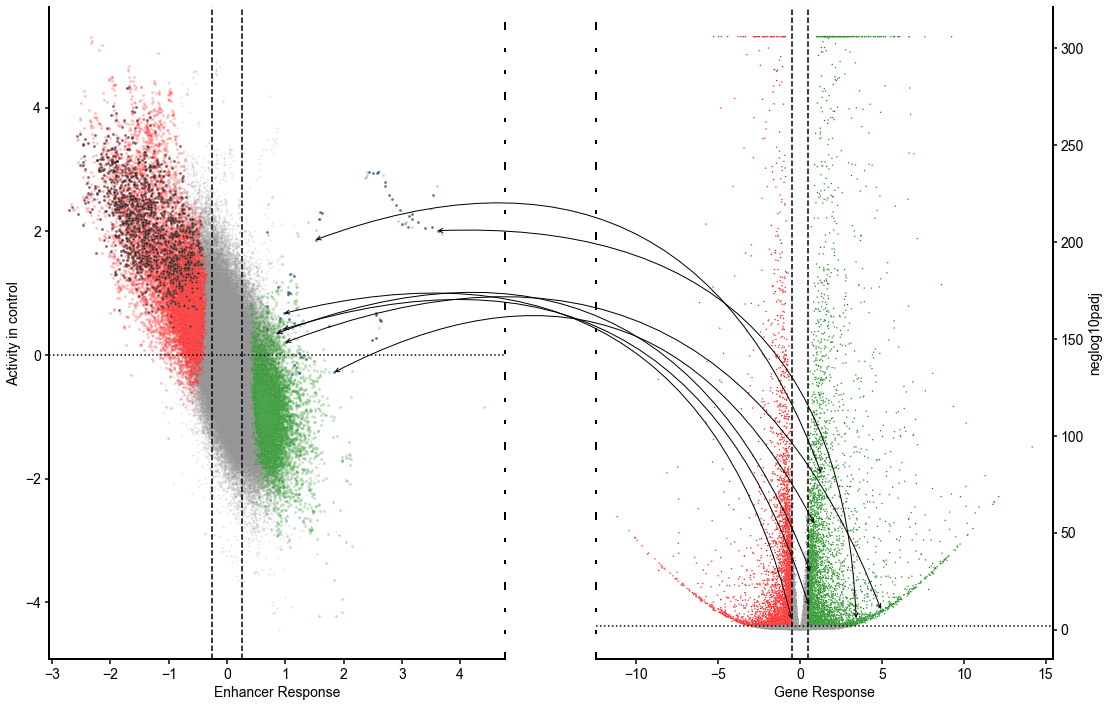

In [112]:
# define canvas
fig, axes = plt.subplots(1, 2, figsize=(18,12))

# Enhancers
sf=4
sns.scatterplot(data=unresponsive_fragments, y="CC", x="abs_mean_fc", s=1*sf, alpha=0.2, color="grey", ax=axes[0], rasterized=True)
sns.scatterplot(data=induced_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.25, color="green", ax=axes[0], rasterized=True)
sns.scatterplot(data=repressed_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.25, color="red", ax=axes[0], rasterized=True)
sns.scatterplot(data=gained_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="navy", ax=axes[0], rasterized=True)
sns.scatterplot(data=lost_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="k", ax=axes[0], rasterized=True)

axes[0].axhline(0, color="k", ls=":")
axes[0].axvline(0.25, color="k", ls="--")
axes[0].axvline(-0.25, color="k", ls="--")
axes[0].spines[['top']].set_visible(False)
axes[0].spines[['right']].set_linestyle((0, (3, 10, 1, 10, 1, 10)))
axes[0].set_xlabel("Enhancer Response")
axes[0].set_ylabel("Activity in control")

# Genes
sns.scatterplot(
    data=volcano_df, x="log2FoldChange", y="neglog10padj", 
    hue="hue", palette={"Significant Down": "red", "Not Significant": "grey", "Significant Up": "green"},
    ax=axes[1], s=2,
    legend=False,
    )
axes[1].axvline(x=0.5, linestyle="--", color="k")
axes[1].axvline(x=-0.5, linestyle="--", color="k")
axes[1].axhline(y=-np.log10(0.01), linestyle=":", color="k")
axes[1].yaxis.tick_right()
axes[1].spines[['top']].set_visible(False)
axes[1].spines[['left']].set_linestyle((0, (3, 10, 1, 10, 1, 10)))
axes[1].yaxis.set_label_position("right")
axes[1].set_xlabel("Gene Response")


# add Enhancer to Gene targets
for xa, ya, xb, yb in zip(tg_df.xact, tg_df.yact, tg_df.xexp, tg_df.yexp):
    con = ConnectionPatch(
        xyA=(xa, ya), coordsA=axes[0].transData,
        xyB=(xb, yb), coordsB=axes[1].transData,
        arrowstyle="<->", connectionstyle="arc3,rad=-0.5")
    fig.add_artist(con)

In [104]:
tg_df

,chrom_coord,sde_genes,xact,yact,xexp,yexp
128595,chr9_132270314_132270814,ENSG00000107290.14,1.842058,-0.278100,0.863862,54.911055
184663,chr17_9389100_9389600,ENSG00000170310.15,1.006506,0.204967,4.928194,10.770290
197429,chr4_105191810_105192310,ENSG00000168769.14,0.852506,0.348198,0.619838,29.968723
202974,chr1_167659423_167659923,ENSG00000198771.11,0.968383,0.416213,0.536171,12.480000
219661,chr14_73228629_73229124,ENSG00000080815.20,0.982045,0.673837,-0.512421,5.587247
248672,chr17_77233402_77233902,ENSG00000129657.16,1.521709,1.863438,1.293161,80.852648
249717,chr8_630175_630675,ENSG00000104714.14,3.613210,2.010016,3.428161,5.921008


In [ ]:
def plot_fragment_category(
    unresponsive_fragments, induced_fragments, repressed_fragments, always_active_fragments, always_inactive_fragments, gained_fragments, lost_fragments, 
    sf=4, figsize=(8, 10), xlim=(-4, 4), ylim=(-5, 6), plot_active_inactive=True):
    fig, axes = plt.subplots(figsize=figsize)
    sns.scatterplot(data=unresponsive_fragments, y="CC", x="abs_mean_fc", s=1*sf, alpha=0.2, color="grey", ax=axes, rasterized=True)
    sns.scatterplot(data=induced_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.25, color="green", ax=axes, rasterized=True)
    sns.scatterplot(data=repressed_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.25, color="red", ax=axes, rasterized=True)
    sns.scatterplot(data=gained_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="navy", ax=axes, rasterized=True)
    sns.scatterplot(data=lost_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="k", ax=axes, rasterized=True)
    if plot_active_inactive:
        sns.scatterplot(data=always_active_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="gold", ax=axes, rasterized=True)
        sns.scatterplot(data=always_inactive_fragments, y="CC", x="abs_max_fc", s=2*sf, alpha=0.5, color="tan", ax=axes, rasterized=True)
    axes.axhline(0, color="k")
    axes.axvline(0.25, color="k", ls="--")
    axes.axvline(-0.25, color="k", ls="--")
    # axes.set_xlim(*xlim)
    # axes.set_ylim(*ylim)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Unresponsive', markerfacecolor='grey', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Induced', markerfacecolor='green', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Repressed', markerfacecolor='red', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Gained', markerfacecolor='navy', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Lost', markerfacecolor='k', markersize=15),
        ]
    if plot_active_inactive:
        legend_elements.extend([
            Line2D([0], [0], marker='o', color='w', label='Always active', markerfacecolor='gold', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='Always inactive', markerfacecolor='tan', markersize=15),
        ])
    axes.spines[['right', 'top']].set_visible(False)
    axes.legend(handles=legend_elements, loc='lower right', frameon=False)
    axes.set_xlabel("Response")
    axes.set_ylabel("Activity in control")
    return fig, axes